In [13]:
# Pull Data From Twitter

In [1]:
import tweepy
import pandas as pd
import csv
import re 
import string
import preprocessor as p
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from collections import  Counter
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
np.random.seed(42)

In [2]:
consumer_key="18GgtxgXKtFNClpxb7iore84G"
consumer_secret="RzqoSkUi5919JWYY2hew6WpTtEXah2PJLOvDwkMFlJfcpS9lgO"
access_token_key="1393585869026697216-HYA8QxK0ShrF9r1mUwzyfm1mqm5Imn"
access_token_secret="h4fVbzG4SgK8yqAL6d18QP4IEEvLyuevEashyprrkfdAp"

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [4]:
user_ids = ["netanyahu", "meravmichaelijs", "naftalibennett", "tamarzandberg", "yairlapid", "ayelet__shaked", "AvigdorLiberman", "regev_miri", "NitzanHorowitz"]

In [11]:
data_per_user = dict()
last_id_per_user = dict()
for user_id in user_ids:
    last_id_per_user[user_id] = -1
    data_per_user[user_id] = []
for user_id in user_ids:
    print("WORKING ON " + user_id)
    last_id = None
    while len(data_per_user[user_id]) < 1:
        if last_id_per_user[user_id] != -1:
            last_id = last_id_per_user[user_id]
        tweets = api.user_timeline(screen_name=user_id, count=200, include_rts = False, exclude_replies=True, tweet_mode = 'extended', max_id = last_id)
        pulled_data = [[tweet.id_str, tweet.created_at, tweet.favorite_count, tweet.retweet_count, tweet.full_text.encode("utf-8").decode("utf-8")] for idx,tweet in enumerate(tweets)]
        data_per_user[user_id].extend(pulled_data)
        if len(tweets) == 0:
                break
        last_id_per_user[user_id] = tweets[-1].id
    print("DONE WITH " + user_id)

WORKING ON netanyahu


NameError: name 'api' is not defined

In [ ]:
for user_id in user_ids:
    df = pd.DataFrame(data_per_user[user_id], columns=["id","created_at","favorite_count","retweet_count", "text"])
    df.to_csv('%s_tweets.csv' % user_id,index=False)

# Data Processing

In [5]:
all_data = pd.DataFrame(columns=["id", "text", "label"])
for user_id in user_ids:
    raw_data = pd.read_csv('%s_tweets.csv' % user_id)
    raw_data["label"] = user_id
    row = raw_data[["id", "text", "label"]]
    all_data = all_data.append(row)
print(all_data)

                       id                                               text  \
0     1400120105783152647  עוד פרטים: https://t.co/rrKuyf4nnA https://t.c...   
1     1400025751848632321  אני מברך את יצחק הרצוג על בחירתו לנשיא המדינה ...   
2     1399768934337945601  הטענה המרכזית בתיק התפור 4000 - קרסה היום בבית...   
3     1399679823786696707  האיום הגדול ביותר עלינו זה האיום הקיומי שמוצב ...   
4     1399670824064462854  למוסד יצא בצדק רב מוניטין של אחד מארגוני הביון...   
...                   ...                                                ...   
2235   886622894738079744  התנגדות המדינה לאימוץ ע״י הורים להטבים מראה שה...   
2236   886279548807110657  עכשיו גם בתל אביב. עדיין רחוק מאוד מהמספרים של...   
2237   885065513096839169  קצת הדתה להיום:\r\nאיכה היתה לזונה קריה נאמנה,...   
2238   884683576662536192  ״ממשלת החלומות של החרדים״ הגדיר את זה @yairche...   
2239   884490381194297344  כוכב הערב - הבן של גבאי. ״אבא יעשה שלטון סוציא...   

               label  
0          netan

In [6]:
# Remove all tweets that are not including hebrew letters
def is_tweet_has_hebrew(text):
    return any("\u0590" <= c <= "\u05EA" for c in text)

non_hebrew = []
hebrew_only = pd.DataFrame(columns=["id", "text", "label"])
for idx, row in all_data.iterrows():
    if not is_tweet_has_hebrew(row["text"]):
        non_hebrew.append(row["text"])
    else:
        row["text"] = row["text"].replace(".", "")
        hebrew_only = hebrew_only.append(row)
print(len(non_hebrew))
print(hebrew_only)

934
                       id                                               text  \
0     1400120105783152647  עוד פרטים: https://tco/rrKuyf4nnA https://tco/...   
1     1400025751848632321  אני מברך את יצחק הרצוג על בחירתו לנשיא המדינה ...   
2     1399768934337945601  הטענה המרכזית בתיק התפור 4000 - קרסה היום בבית...   
3     1399679823786696707  האיום הגדול ביותר עלינו זה האיום הקיומי שמוצב ...   
4     1399670824064462854  למוסד יצא בצדק רב מוניטין של אחד מארגוני הביון...   
...                   ...                                                ...   
2235   886622894738079744  התנגדות המדינה לאימוץ ע״י הורים להטבים מראה שה...   
2236   886279548807110657  עכשיו גם בתל אביב עדיין רחוק מאוד מהמספרים של ...   
2237   885065513096839169  קצת הדתה להיום:\r\nאיכה היתה לזונה קריה נאמנה,...   
2238   884683576662536192  ״ממשלת החלומות של החרדים״ הגדיר את זה @yairche...   
2239   884490381194297344  כוכב הערב - הבן של גבאי ״אבא יעשה שלטון סוציאל...   

               label  
0          n

In [7]:
all_data = hebrew_only

In [8]:
# Num of tweets grouped by type - general data 
print(all_data['label'].nunique())
all_data.groupby(['label'])['id'].count()

9


label
AvigdorLiberman    1933
NitzanHorowitz     2213
ayelet__shaked     2237
meravmichaelijs    1632
naftalibennett     2046
netanyahu          1883
regev_miri         2999
tamarzandberg      1827
yairlapid          2529
Name: id, dtype: int64

In [9]:
def plot_top_non_stopwords_barchart(text, stop):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (len(word)>1 and word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=invert_words(x))

In [10]:
def plot_top_ngrams_barchart(text, n=2):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=invert_words(x))

In [11]:
my_punctuation = string.punctuation.replace(",", "").replace(".","").replace("?","").replace("!","")
def remove_pe(text, p =string.punctuation):
    "remove punctuation and emojis"
    text_without = "".join([c for c in text if c not in p])
    text_without_pe =  emoji.get_emoji_regexp().sub(r'', text_without)
    return text_without_pe

def removeWeirdChars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weridPatterns.sub(r'', text)

In [12]:
def invert_words(words):
    return [w[::-1] for w in words]

def get_hebrew_stopwords():
    stop_path="./heb_stopwords.txt"
    with open(stop_path, encoding="utf-8") as in_file:
        lines=in_file.readlines()
        res=[l.strip() for l in lines]
        print(res[:4])
    return res

stop=get_hebrew_stopwords()
extra_words = ["QA", "the", "and", "to"]
stop += extra_words

['את', 'לא', 'של', 'אני']


In [88]:
all_data['text'] = all_data['text'].apply(lambda x: remove_pe(x, my_punctuation))\
                                 .apply(lambda x: re.sub(r'[A-Za-z]|http\S+|[0-9]+', '',x))\
                                 .apply(lambda x: removeWeirdChars(x))
print(all_data)

                       id                                               text  \
0     1400120105783152647                                        עוד פרטים     
1     1400025751848632321  אני מברך את יצחק הרצוג על בחירתו לנשיא המדינה ...   
2     1399768934337945601   הטענה המרכזית בתיק התפור   קרסה היום בבית המשפט    
3     1399679823786696707  האיום הגדול ביותר עלינו זה האיום הקיומי שמוצב ...   
4     1399670824064462854  למוסד יצא בצדק רב מוניטין של אחד מארגוני הביון...   
...                   ...                                                ...   
2235   886622894738079744  התנגדות המדינה לאימוץ ע״י הורים להטבים מראה שה...   
2236   886279548807110657  עכשיו גם בתל אביב עדיין רחוק מאוד מהמספרים של ...   
2237   885065513096839169  קצת הדתה להיום\r\nאיכה היתה לזונה קריה נאמנה, ...   
2238   884683576662536192  ״ממשלת החלומות של החרדים״ הגדיר את זה   איך זה...   
2239   884490381194297344  כוכב הערב  הבן של גבאי ״אבא יעשה שלטון סוציאלי...   

               label  
0          netan

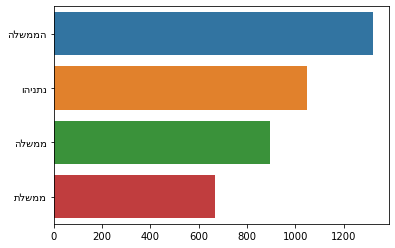

In [14]:
plot_top_non_stopwords_barchart(all_data["text"], stop)

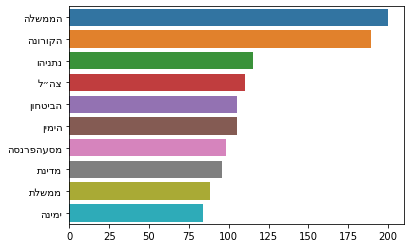

In [15]:
plot_top_non_stopwords_barchart(all_data[all_data["label"]==user_ids[5]]["text"], stop)

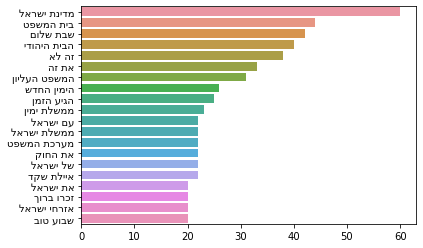

In [51]:
plot_top_ngrams_barchart(all_data[all_data["label"]==user_ids[5]]["text"], 2)

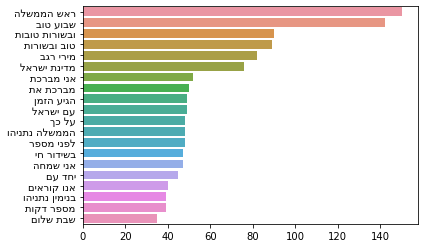

In [52]:
plot_top_ngrams_barchart(all_data[all_data["label"]==user_ids[7]]["text"], 2)

In [91]:
shuffled_data = all_data.sample(frac=1).reset_index(drop=True)

In [92]:
y = shuffled_data.pop("label")
x = shuffled_data

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [19]:
# TODO: ADD GRAPHS!

In [93]:
# Modify y_test shape to fit evaluator
y_test.loc[:,"text"]=x_test["text"]
y_test = y_test.rename(columns={"label": "label"})

In [94]:
from evaluate import Evaluator
evaluator=Evaluator(y_test)

test_df has 3860 rows


In [45]:
import re

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[\u0590-\u05EA][\u0590-\u05EA'\-_]+[\u0590-\u05EA])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
    ]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)


def preprocess(s):
    tokens = tokenize(s)
    toks = []
    emoji = ""
    for val in tokens:
        if len(val) > 1:
            toks.append(val)
            if len(emoji) > 0:
                toks.append("*אייקון*")
                emoji = ""

        elif len(val) == 1 and ord(val) < 128:
            toks.append(val)
            if len(emoji) > 0:
                toks.append("*אייקון*")
                emoji = ""

        else:
            emoji += val

    if len(emoji) > 0:
        toks.append("*אייקון*")
        emoji = ""

    return " ".join(toks)

X = [preprocess(x[1]["text"]) for x in x_train.iterrows()]


In [95]:
count_vectorizer=CountVectorizer(analyzer='word', ngram_range=(1, 2))
transformer=TfidfTransformer()
algo= SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-4, n_iter_no_change=20, random_state=42)
pipe = Pipeline([('vectorizer', count_vectorizer),
                    ('transformer', transformer),
                 ('algo', algo)])
pipe.fit(x_train["text"], y_train["label"])
predicted = pipe.predict(x_test["text"])
evaluator.evaluate(predicted)

Micro precision:0.6823834196891192, recall:0.6823834196891192, f1:0.6823834196891192
Macro precision:0.6918205938903715, recall:0.6813020164750729, f1:0.6821654211594433
Accuracy: 0.6823834196891192
[[275   1  17   6  23  12  14  21   5]
 [  0 303   2   8   5   8   2   4  15]
 [ 11   1 287   7  24  18  12  20  13]
 [  7   8  11 197  43  11   7  25  58]
 [ 14   2  11  17 376  13  17  26  37]
 [ 20   7  35  23  43 213  23  54  36]
 [ 12   2  15   8  44  27 215  53  21]
 [ 17   5  19  12  21  25  20 441  21]
 [  8   5  10  29  26   7  10  12 327]]
LABEL:  netanyahu F1:  0.7452574525745258  PREC:  0.7554945054945055  REC:  0.7352941176470589
LABEL:  meravmichaelijs F1:  0.8898678414096917  PREC:  0.907185628742515  REC:  0.8731988472622478
LABEL:  naftalibennett F1:  0.7175  PREC:  0.7051597051597052  REC:  0.7302798982188295
LABEL:  tamarzandberg F1:  0.5845697329376855  PREC:  0.6416938110749185  REC:  0.5367847411444142
LABEL:  yairlapid F1:  0.6726296958855099  PREC:  0.621487603305785

In [98]:
evaluator.show_errors(predicted, 30, "ayelet__shaked")

overall, there are 241 instances with wrong kind
 שנים למותו של אורי סיפרתי היום באזכרה על אדם שאין לו תחליף שמרן וליברל, עקשן ופשרן עם כישרון כתיבה שאין שני לו, ומנהיגות שקטה ועוצמתית כמו שכתוב על מצבתו ״הוליך אחריו רבים בדרכו השקטה״ יהי זכרו ברוך  true:  ayelet__shaked predicted:  tamarzandberg

הנושא קרוב ללבי ששום קמפיין בחירות לא ידחה אכן מתפללת ששירלי פינטו תהיה בכנסת  true:  ayelet__shaked predicted:  tamarzandberg

כשהשקר הופך לאמת והאמת לשקר, צריך דוברת מוכשרת, אחת  שהצליחה לשווק את ההתנתקות בהתלהבות וחיפשה בית פוליטי במפלגת העבודה  true:  ayelet__shaked predicted:  NitzanHorowitz

בדיון על חוק הלאום בכנסת 

זהו חוק היסטורי
הערכים הדמוקרטים של המדינה מעוגנים בחוק יסוד
יש כאן הזדמנות גדולה לעגן גם את הערכים היהודים  true:  ayelet__shaked predicted:  tamarzandberg

שמחה על הבהרת מבקר המדינה גם לעובדים מגיעה הזכות לפרטיות אף אחד לא יפשפש להם בוואטסאפ או במייל הפרטי true:  ayelet__shaked predicted:  regev_miri

כיתות אב יכולים לחזור ללמוד בקפסולות  ימים בשבוע בלי תוספת תקציב, אם ר